### Find latent features in Place cells using Matrioshka SAEs

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [ ]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from IPython.display import HTML
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm


from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

from mini import train as mt
from mini.util import vec_r2

In [82]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Load simulated place cells spike matrix (this matrix has data from 4 simulated place cells and 96 random cells - aka noise)

spike_matrix = np.load("./spike_matrix.npy")

print(spike_matrix.shape) 

(100, 300000)


In [84]:
# We want it the other way around, neurons = columns and rows = timepoints

spike_matrix = spike_matrix.T

print(spike_matrix.shape)

(300000, 100)


### Train MSAE

In [85]:
dsae_topk_map = {64: 1, 128: 2, 256: 4}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {64: 1, 128: 1.25, 256: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
dsae = max(dsae_topk_map.keys())
n_inst = 2

In [86]:
# gonna want a gpu if training! not necessary if loading saved features from a trained model
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


In [87]:
# convert to torch tensor and normalize spike counts

spike_cts = t.from_numpy(spike_matrix).bfloat16().to(device)
#spike_cts /= spike_cts.max()

mean = spike_cts.mean(dim=0, keepdim=True)
std = spike_cts.std(dim=0, keepdim=True)
spike_cts = (spike_cts - mean) / (std) + 1e-8

In [88]:
sae_cfg = mt.SaeConfig(
    n_input_ae=spike_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 2
batch_sz = 16
n_steps = spike_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spike_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step:   0%|          | 0/37500 [00:00<?, ?it/s, loss=0.10045,  l0_mean=4.0, l0_std=12.075034141540527, frac_dead=0.0]

SAE batch training step: 100%|██████████| 37500/37500 [05:22<00:00, 116.24it/s, loss=0.04778,  l0_mean=4.0, l0_std=9.456180572509766, frac_dead=0.015625]  


## Validate SAEs

In [89]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

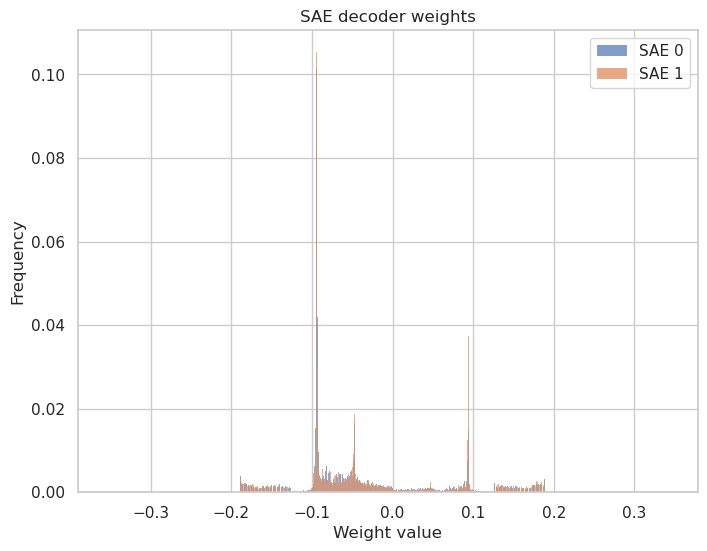

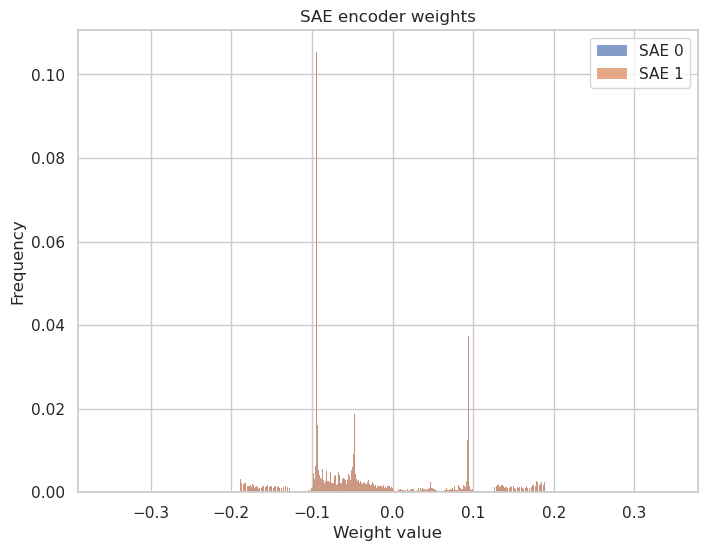

In [90]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_enc_flat = asnumpy(sae.W_enc[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE encoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step:   0%|          | 76/18750 [00:00<00:24, 750.81it/s]

SAE batch evaluation step: 100%|██████████| 18750/18750 [00:24<00:00, 754.45it/s]
/mini/.pixi/envs/default/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/mini/.pixi/envs/default/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


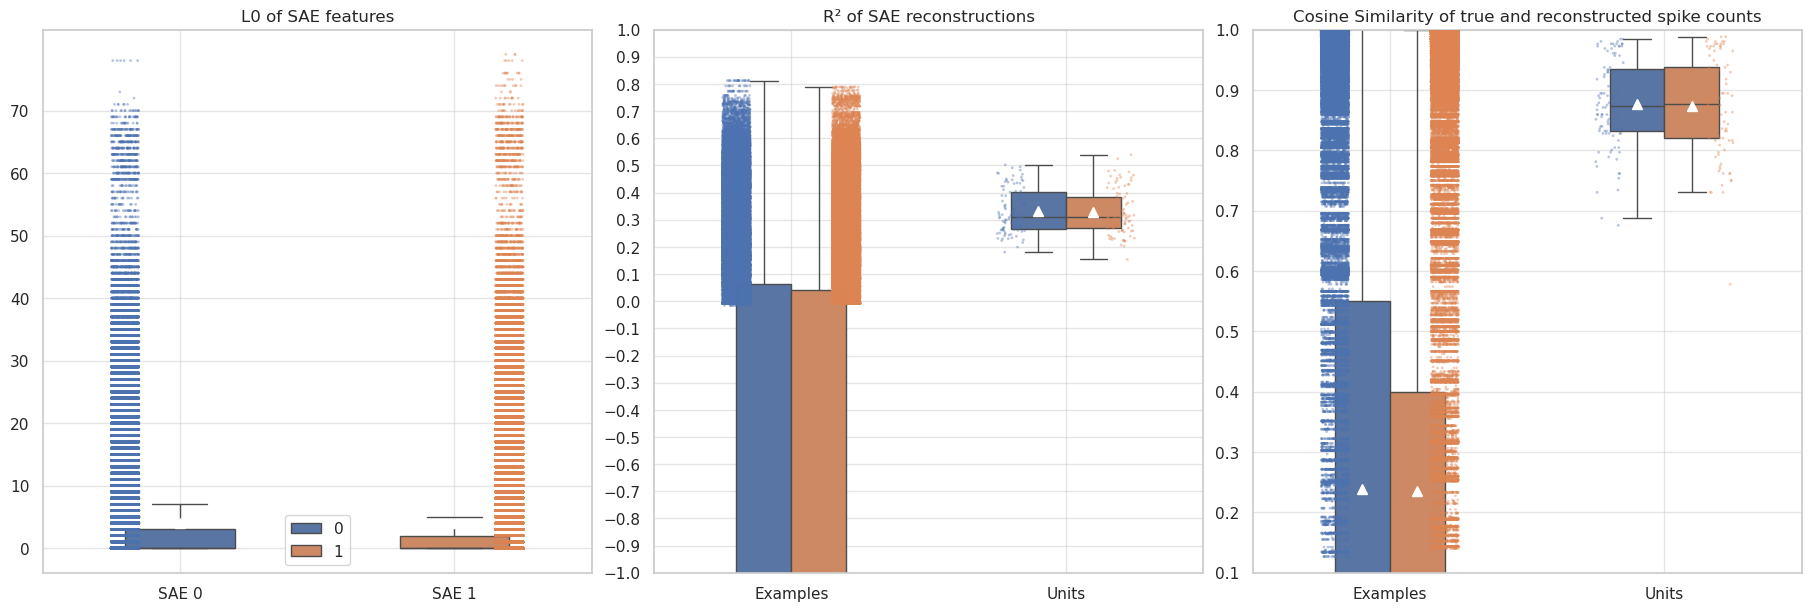

In [91]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spike_cts, sae, batch_sz=batch_sz)

In [92]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spike_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.411
SAE instance 1 R² (summed spike count over all units per example) = 0.411


## Remove bad units and retrain

In [36]:
"""#Re-train.

r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spike_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-4

n_epochs = 20
batch_sz = 16
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)"""

'#Re-train.\n\nr2_thresh = 0.1\ninst = 0\nr2_per_unit = r2_per_unit[:, inst]\nkeep_mask = r2_per_unit > r2_thresh\nprint(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")\nprint(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")\n\n# Remove units and retrain\nspk_cts = spike_cts[:, keep_mask]\n\nsae_cfg = mt.SaeConfig(\n    n_input_ae=spk_cts.shape[1],\n    dsae_topk_map=dsae_topk_map,\n    dsae_loss_x_map=dsae_loss_x_map,\n    seq_len=1,\n    n_instances=n_inst,\n)\nsae = mt.Sae(sae_cfg).to(device)\nloss_fn = mt.msle\ntau = 1.0\nlr = 5e-4\n\nn_epochs = 20\nbatch_sz = 16\nn_steps = spk_cts.shape[0] // batch_sz * n_epochs\nlog_freq = n_steps // n_epochs // 2\ndead_neuron_window = n_steps // n_epochs // 3\n\ndata_log = mt.optimize(  # train model\n    spk_cts=spk_cts,\n    sae=sae,\n    loss_fn=loss_fn,\n    optimizer=t.optim.Adam(sae.parameters(), lr=lr),\n    use_lr_sched=True,\n    dead_neuron_window=dead_neuron_window,\n    n_steps=n_steps,\n    

In [37]:
"""#Re-visualize metrics over all examples and units.

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")"""


'#Re-visualize metrics over all examples and units.\n\ntopk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)\n\nn_recon_examples = recon_spk_cts.shape[0]\nrecon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")\nactual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")\nactual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match\nfor inst in range(n_inst):\n    r2 = r2_score(\n        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())\n    )\n    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")'

## Interpret features

In [74]:

out_dir = Path("/workspace/SAE_place_cells/")
session_id = "31-08-2025_12_47_55"  # change to your session id

load_acts = False  # if True, will load saved feature activations
save_acts = False
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [39]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

print(acts_df.head(5))

   example_idx  instance_idx  feature_idx  activation_value
0            0             0            9             0.125
1            0             0           78             0.125
2            0             0           92             0.125
3            0             0          102             0.125
4            0             0          105             0.125


In [40]:
display(acts_df)

example_idx  instance_idx  feature_idx  activation_value
0                  0             0            9          0.125000
1                  0             0           78          0.125000
2                  0             0           92          0.125000
3                  0             0          102          0.125000
4                  0             0          105          0.125000
...              ...           ...          ...               ...
2399995       299998             1          268          0.208984
2399996       299998             1          293          0.204102
2399997       299998             1          329          0.143555
2399998       299998             1          361          0.197266
2399999       299998             1          376          0.183594

[2400000 rows x 4 columns]

In [75]:
"""Compare features from ("broad" or "general") and ("specific" or "nested") levels.

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[np.logical_and(
    features_df["feature_idx"] > last_feat_idx_general,
    features_df["feature_idx"] < first_feat_idx_specific
)]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())"""

'Compare features from ("broad" or "general") and ("specific" or "nested") levels.\n\nlast_feat_idx_general = list(dsae_topk_map.keys())[0]\nfirst_feat_idx_specific = list(dsae_topk_map.keys())[1]\n\nprint(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())\nprint()\nprint(features_df[np.logical_and(\n    features_df["feature_idx"] > last_feat_idx_general,\n    features_df["feature_idx"] < first_feat_idx_specific\n)]["activation_frac"].describe())\nprint()\nprint(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())'

## Hunt for features

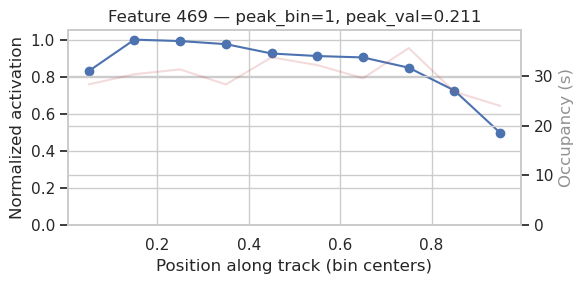

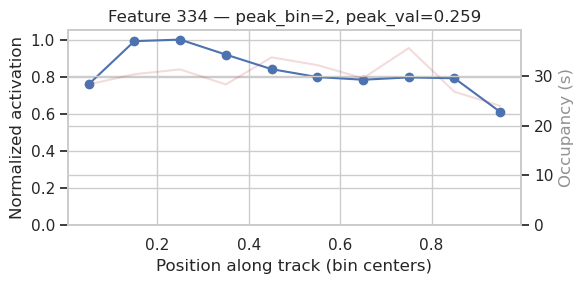

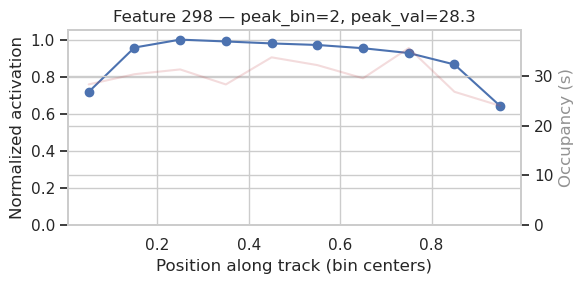

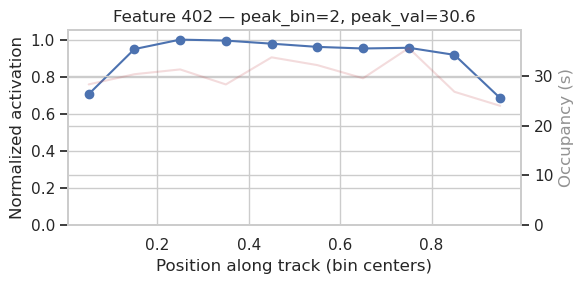

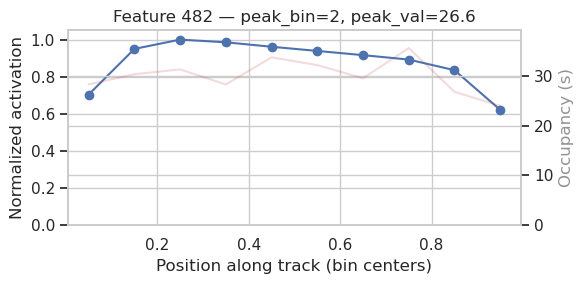

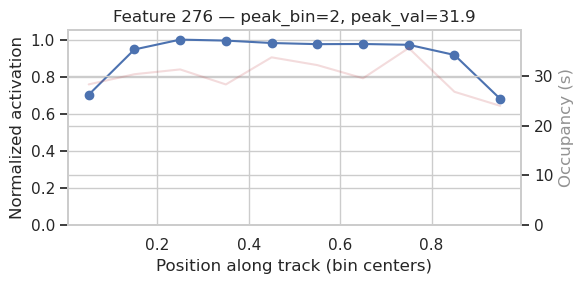

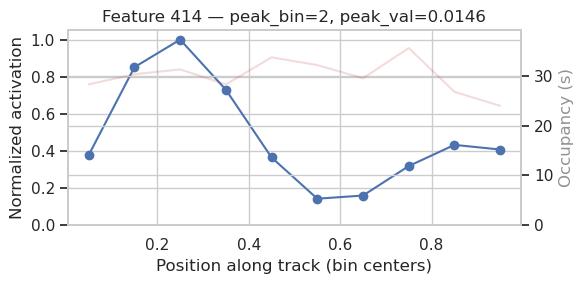

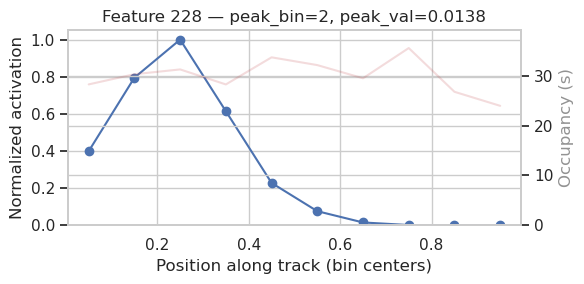

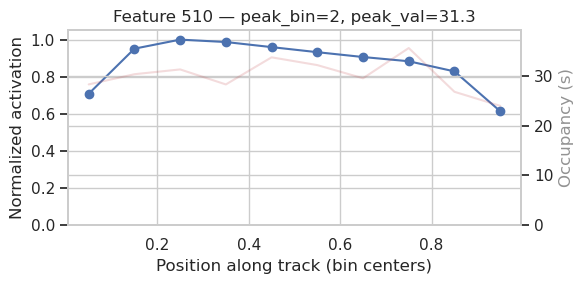

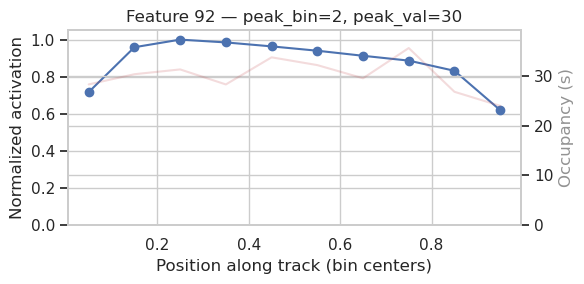

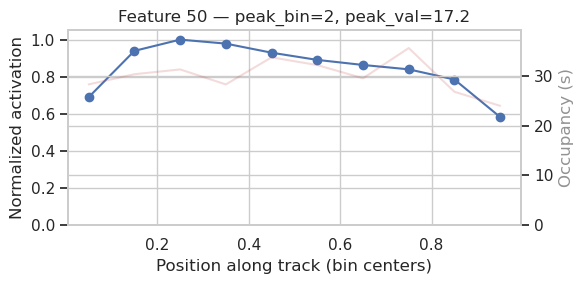

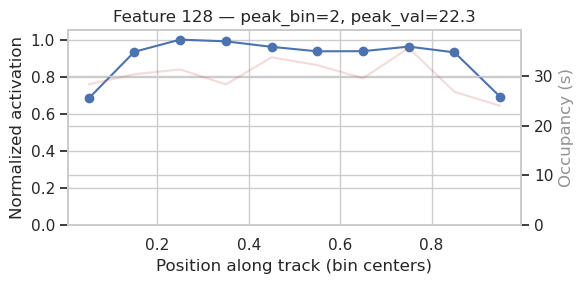

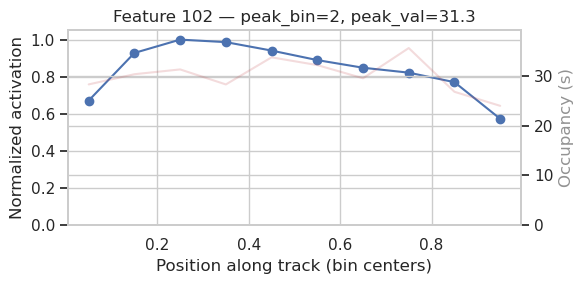

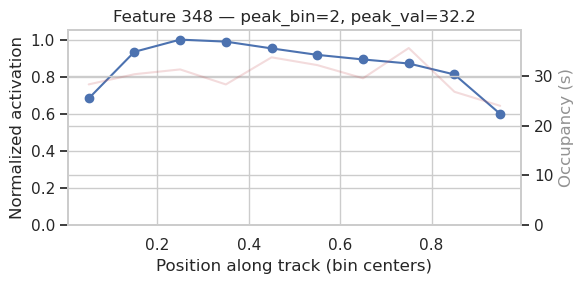

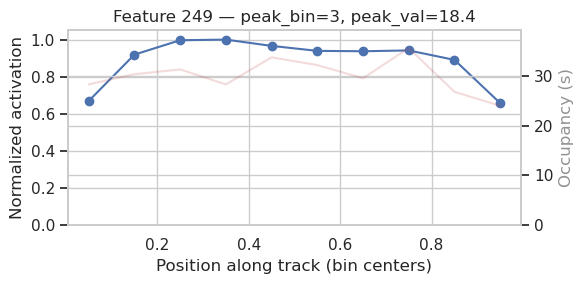

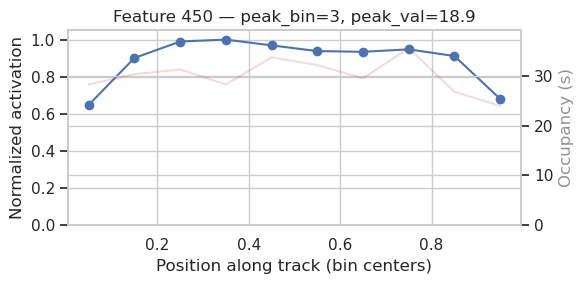

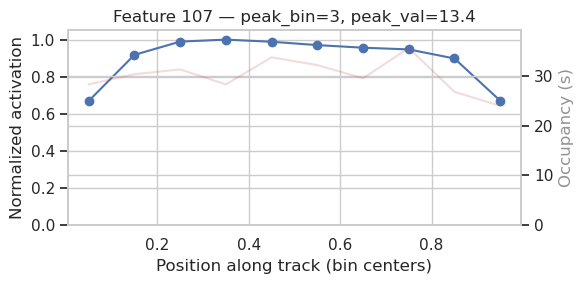

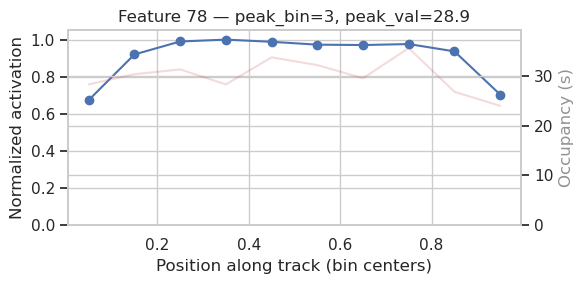

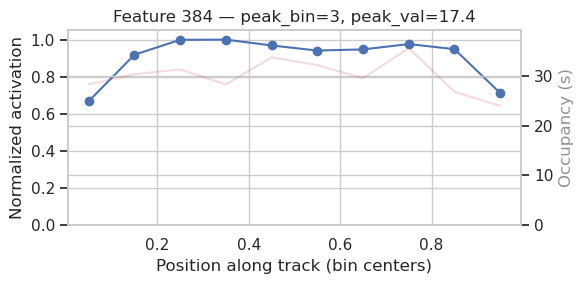

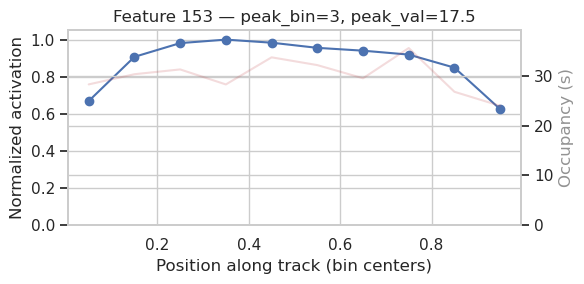

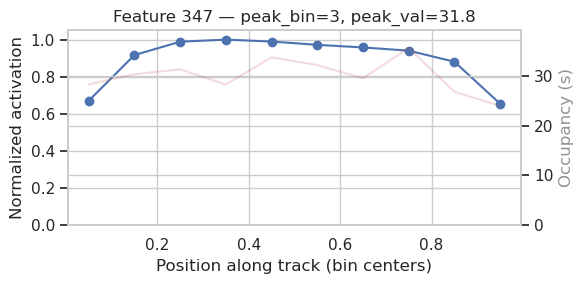

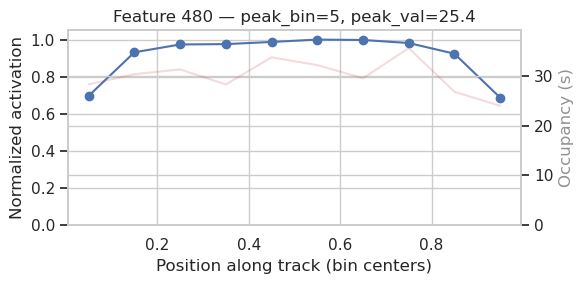

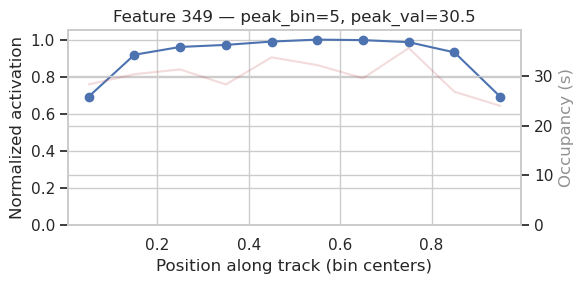

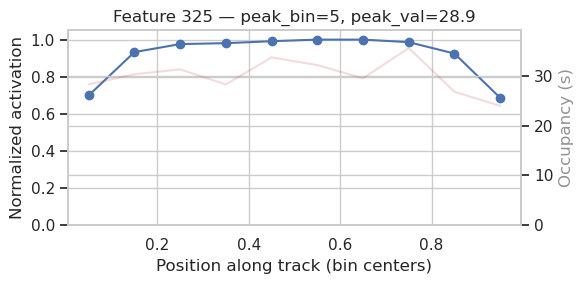

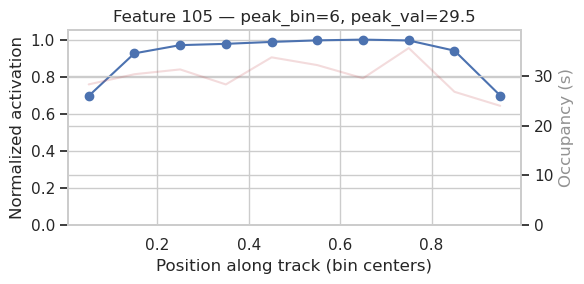

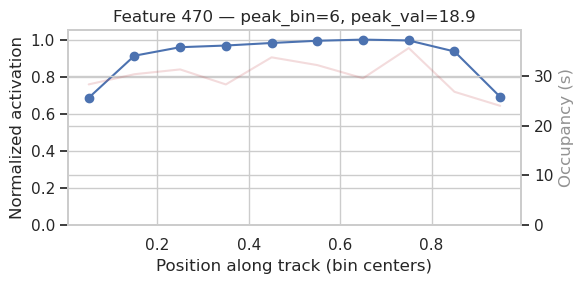

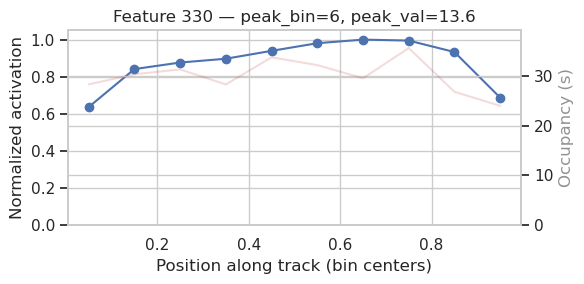

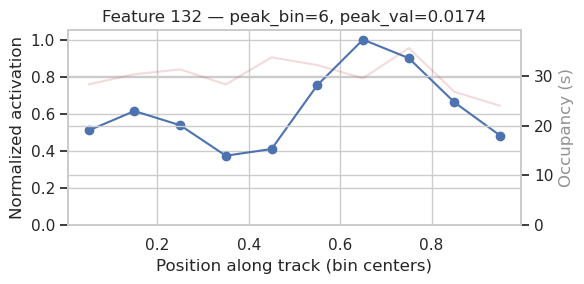

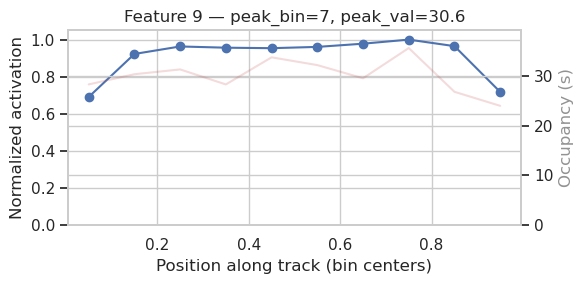

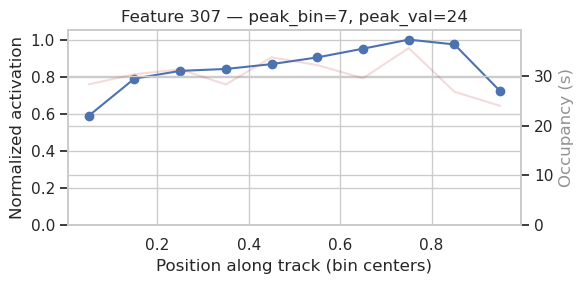

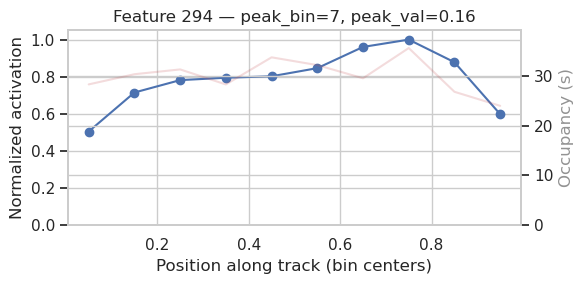

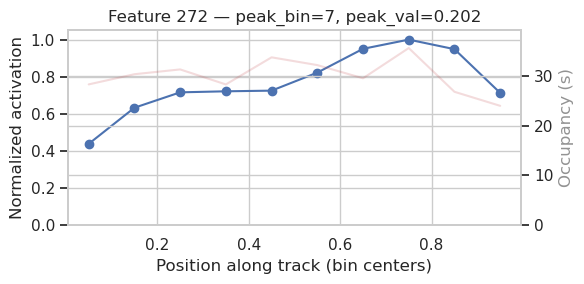

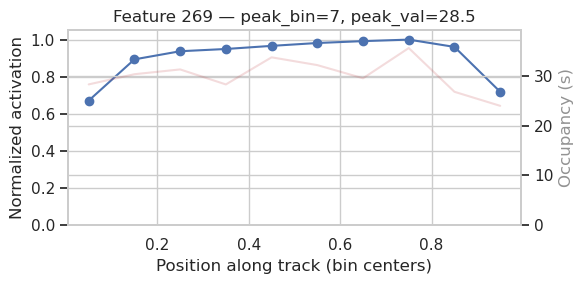

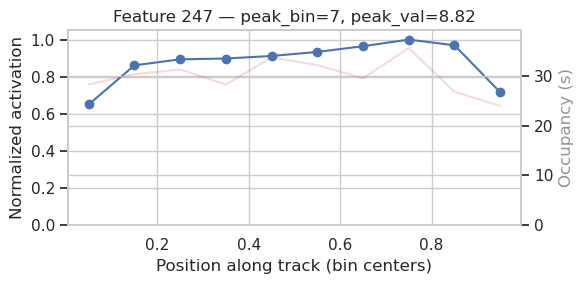

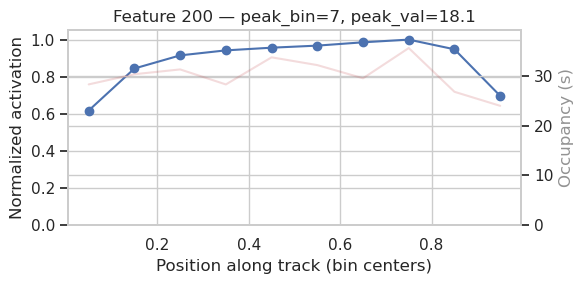

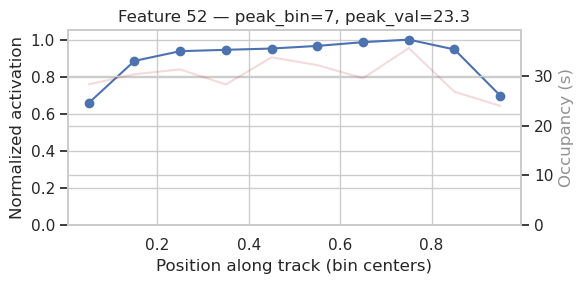

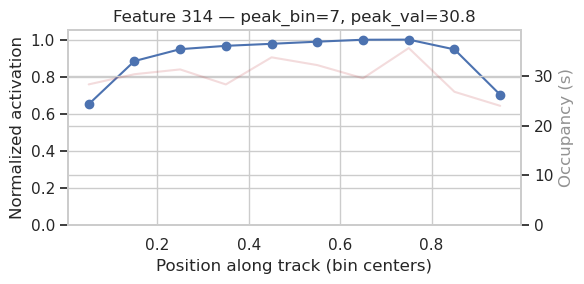

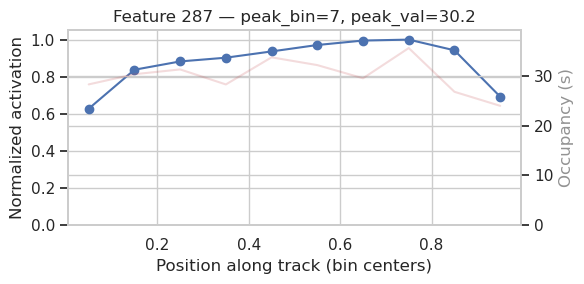

Done. Ratemaps saved to: feature_ratemaps


In [93]:
"""For a particular feature, get times it fired + stim deta at these times."""

# Inputs you already have:
# pos: shape (T,) continuous linear position
# features_df["feature_idx"]:   shape (T, F) continuous activations (or binary 0/1)
# features_df["example_idx"]:   shape (T,) time vector (optional) or assume uniform sampling dt

from scipy.ndimage import gaussian_filter1d
import os

features_df = acts_df[acts_df["instance_idx"] == 0].reset_index(drop=True)  # choose instance

# Parameters (tune as needed)
n_bins = 10
sigma_bins = 1.0            # smoothing sigma in bin units. Set to 0 to skip smoothing.
min_occupancy_s = 0.2       # seconds minimum occupancy per bin; set 0 to ignore
save_dir = "feature_ratemaps"  # set None to show inline instead of saving
row_normalize = True        # if True, scale each feature's ratemap to [0,1] for visualization
plot_type = "line"          # "line" or "bar" (per feature)
figsize = (6,3)

# -----------------------------------------------------------------------

# Basic checks
assert 'feature_idx' in features_df.columns and 'example_idx' in features_df.columns, \
    "features_df must contain 'feature_idx' and 'example_idx' columns."

# If activation values exist, use them; else create implied activation_value = 1 per row (count)
if 'activation_value' in features_df.columns:
    features_df['activation_value'] = features_df['activation_value'].astype(float)
else:
    features_df['activation_value'] = 1.0

# Convert pos & t to numpy
pos = np.load("./positions.npy")
time = np.load("./timepoints.npy")
T = len(pos)
if 'time' in globals():
    t = np.asarray(time)
    # estimate dt as median diff; if irregular sampling you might compute occupancy per-sample differently
    dt = np.median(np.diff(t))
else:
    dt = 1.0   # assume uniform sampling; occupancy in "samples" units

# 1) define spatial bins and occupancy
edges = np.linspace(pos.min(), pos.max(), n_bins + 1)
bin_idx_all = np.digitize(pos, edges) - 1
bin_idx_all = np.clip(bin_idx_all, 0, n_bins-1)

# occupancy in seconds per bin
counts = np.bincount(bin_idx_all, minlength=n_bins)
T_bins = counts * dt
p_bins = T_bins / T_bins.sum()

# optionally mask low-occupancy bins
low_occ_mask = T_bins < min_occupancy_s

# 2) Map feature activations (rows) to bins using example_idx -> pos -> bin
# Make sure example_idx is integer and indices are within range
features_df = features_df.copy()
features_df['example_idx'] = features_df['example_idx'].astype(int)
features_df = features_df[(features_df['example_idx'] >= 0) & (features_df['example_idx'] < T)].reset_index(drop=True)
# Map example -> position bin
features_df['bin'] = bin_idx_all[features_df['example_idx'].values]

# 3) Aggregate activations per feature x bin
# We compute sum of activation_value per (feature, bin). For counts-based data this is just counts.
agg = features_df.groupby(['feature_idx', 'bin'])['activation_value'].sum().unstack(fill_value=0)  # shape: (n_features, n_bins)
# ensure all bins exist as columns
agg = agg.reindex(columns=np.arange(n_bins), fill_value=0)

# 4) Convert aggregated activations to occupancy-normalized ratemap
# rate = total_activation_in_bin / occupancy_seconds_in_bin
# If dt units are samples, this gives activations per second if activation_value counted spikes per sample
occ = T_bins.copy().astype(float)
occ[occ == 0] = np.nan  # avoid division by zero; we'll mask these later
ratemap = agg.values / occ[np.newaxis, :]   # shape (n_features, n_bins)

# 5) smoothing (optional)
if sigma_bins > 0:
    # for a linear track use mode='constant' to avoid wrap-around
    ratemap_sm = gaussian_filter1d(ratemap, sigma=sigma_bins, axis=1, mode='constant')
else:
    ratemap_sm = ratemap

# 6) prepare plotting folder
if save_dir is not None:
    os.makedirs(save_dir, exist_ok=True)

# Function to compute a simple selectivity metric (peak / mean) for ordering
peak_over_mean = (ratemap_sm.max(axis=1) + 1e-12) / (np.nanmean(ratemap_sm, axis=1) + 1e-12)
# order features by peak bin (so place-like fields line up) or by peak_over_mean
peak_bin = np.nanargmax(ratemap_sm, axis=1)
order = np.argsort(peak_bin)  # primary sort by peak location
# alternative: order = np.argsort(-peak_over_mean)  # by selectivity

# 7) iterate and plot each feature's ratemap
import math
from matplotlib import gridspec

feature_ids = agg.index.values
for i_feat in order:
    feat = feature_ids[i_feat]  # actual feature_idx label (could be non-contiguous)
    row = ratemap_sm[i_feat, :].copy()
    # mask low-occupancy bins for plotting clarity
    row_vis = row.copy()
    row_vis[low_occ_mask] = np.nan

    if row_normalize:
        mx = np.nanmax(row_vis)
        if np.isfinite(mx) and mx > 0:
            row_vis = row_vis / mx

    # build plot
    fig, ax = plt.subplots(figsize=figsize)
    bins_centers = (edges[:-1] + edges[1:]) / 2.0

    if plot_type == "line":
        ax.plot(bins_centers, row_vis, marker='o', linestyle='-')
        ax.set_ylim(0, 1.05 if row_normalize else None)
    else:  # bar
        ax.bar(bins_centers, row_vis, width=(edges[1]-edges[0])*0.9, align='center')
        if row_normalize:
            ax.set_ylim(0,1.05)

    ax.set_xlabel("Position along track (bin centers)")
    ax.set_ylabel("Normalized activation" if row_normalize else "Activation / sec")
    ax.set_title(f"Feature {feat} — peak_bin={peak_bin[i_feat]}, peak_val={ratemap_sm[i_feat].max():.3g}")
    # optionally annotate occupancy under plot
    ax2 = ax.twinx()
    ax2.plot(bins_centers, T_bins, color='r', alpha=0.2)
    ax2.set_ylabel("Occupancy (s)", alpha=0.5)
    ax2.set_ylim(0, max(T_bins)*1.1)

    plt.tight_layout()
    plt.show()

    if save_dir:
        fname = os.path.join(save_dir, f"ratemap_feature_{feat}.png")
        fig.savefig(fname, dpi=150)
        plt.close(fig)

# 8) Summary DF of metrics (optional)
metrics_df = pd.DataFrame({
    "feature_idx": feature_ids,
    "peak_bin": peak_bin,
    "peak_value": ratemap_sm.max(axis=1),
    "mean_value": np.nanmean(ratemap_sm, axis=1),
    "selectivity": peak_over_mean
})
metrics_df = metrics_df.sort_values(['peak_bin', 'selectivity'], ascending=[True, False]).reset_index(drop=True)
metrics_df.to_csv(os.path.join(save_dir, "feature_ratemap_metrics.csv"), index=False)
print("Done. Ratemaps saved to:", save_dir)



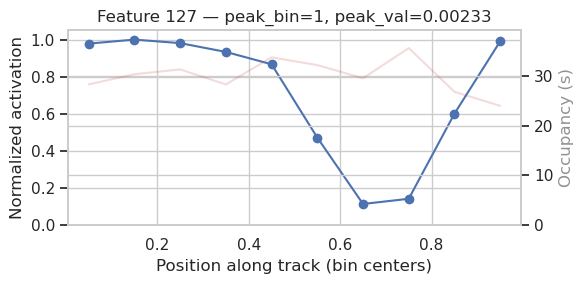

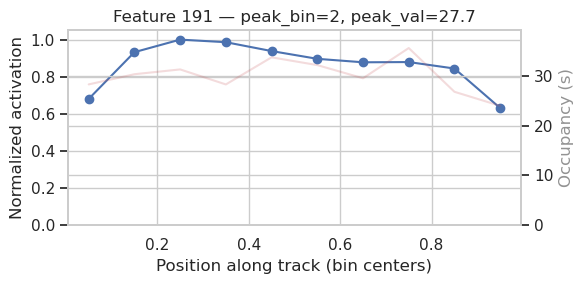

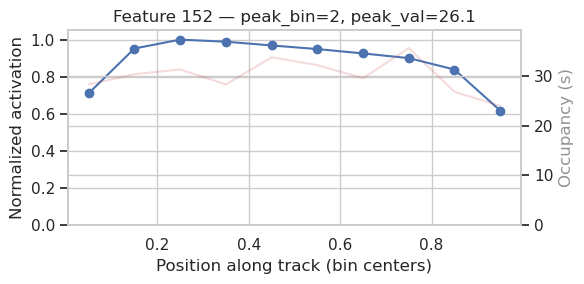

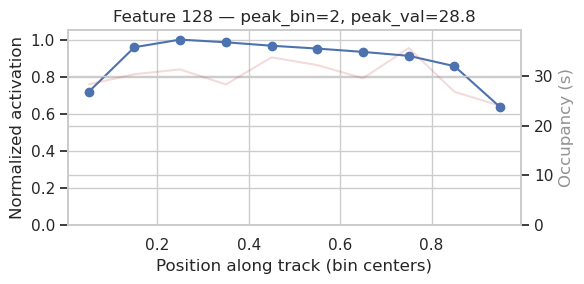

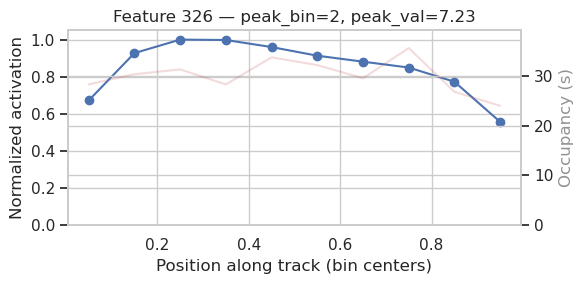

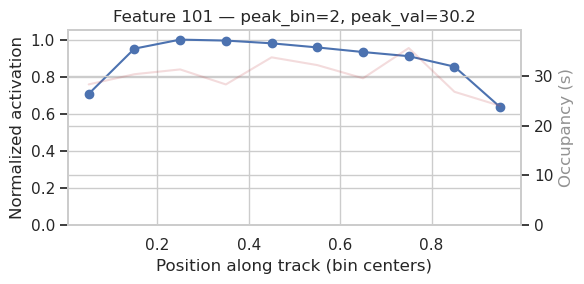

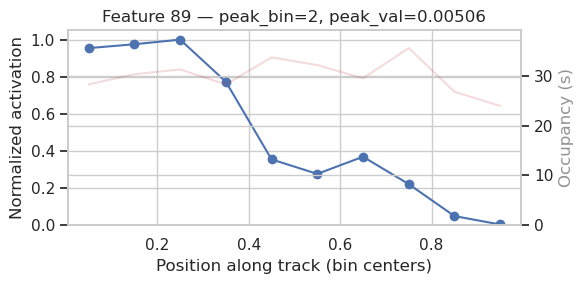

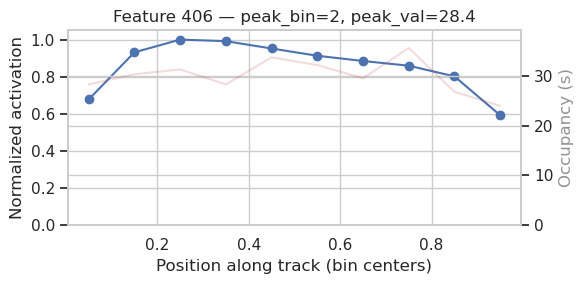

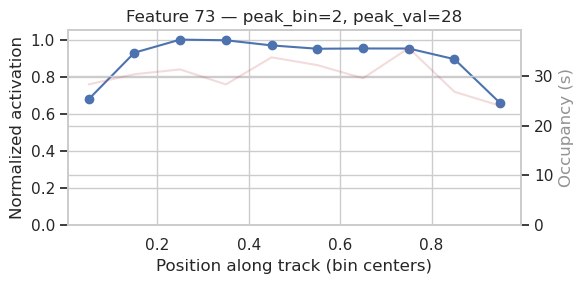

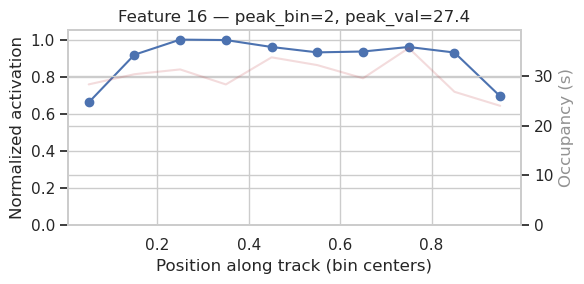

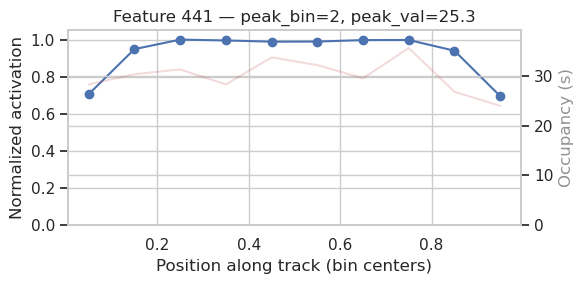

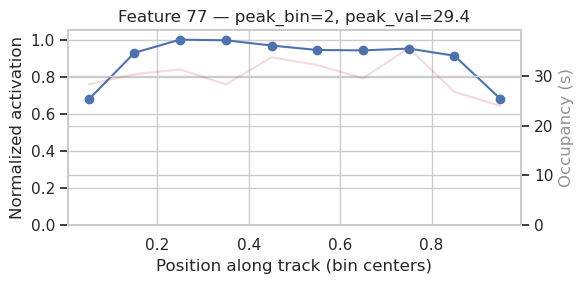

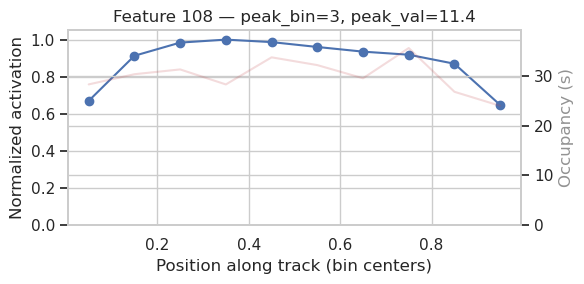

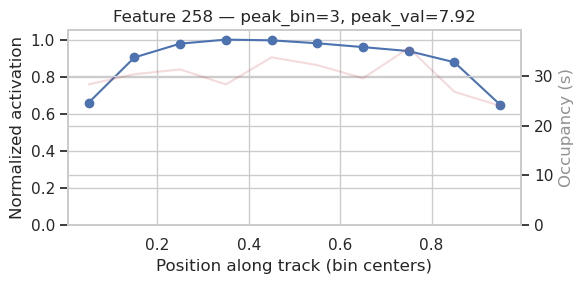

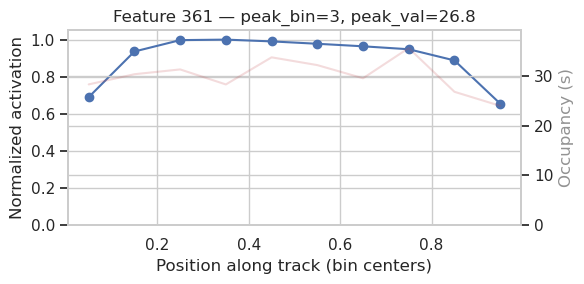

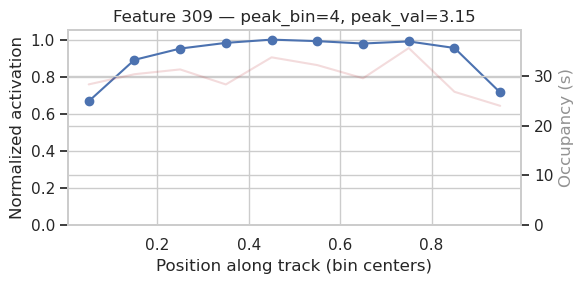

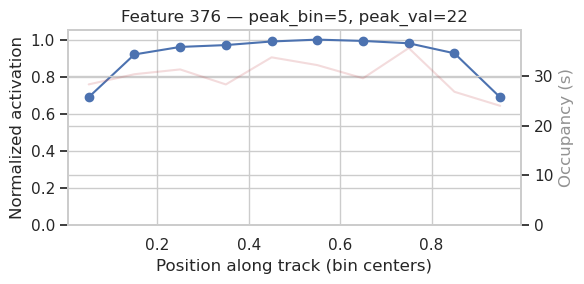

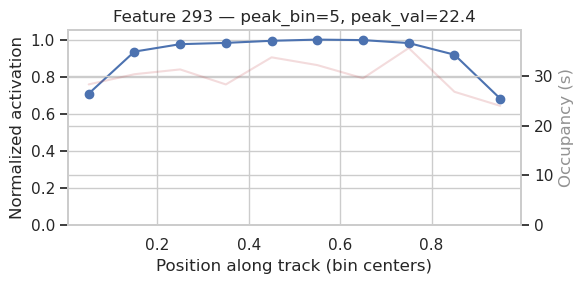

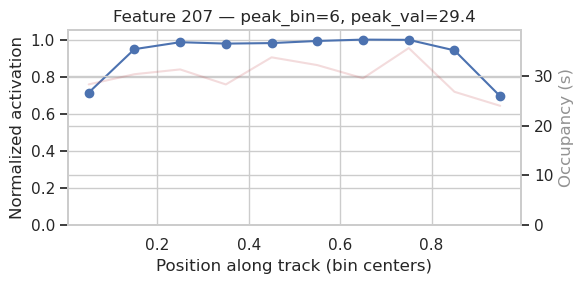

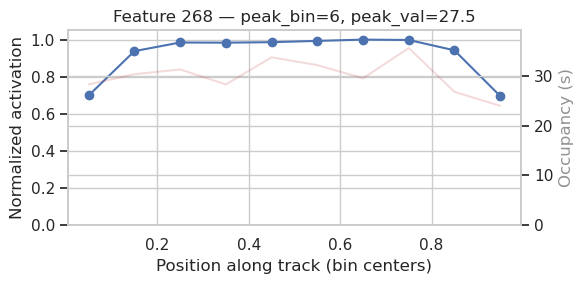

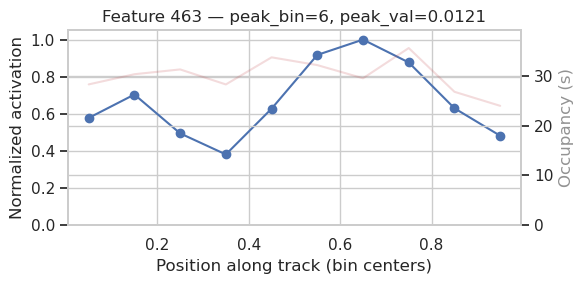

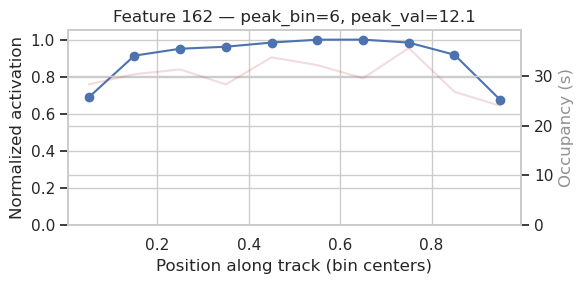

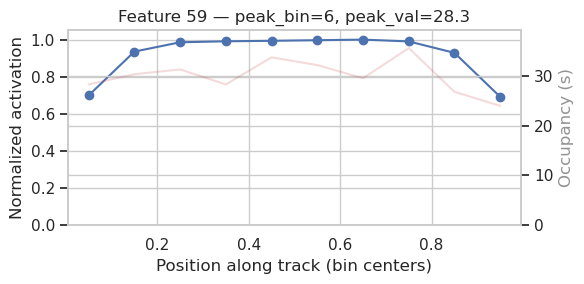

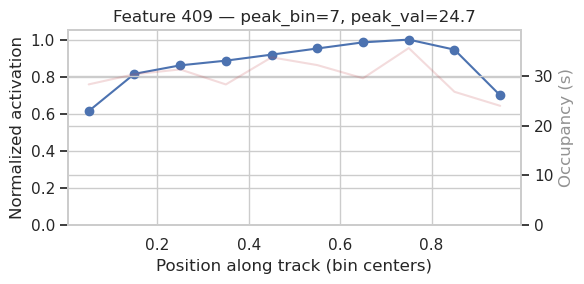

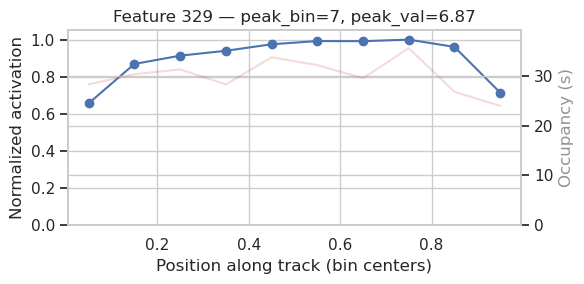

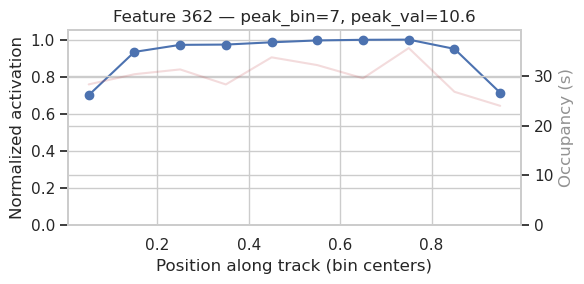

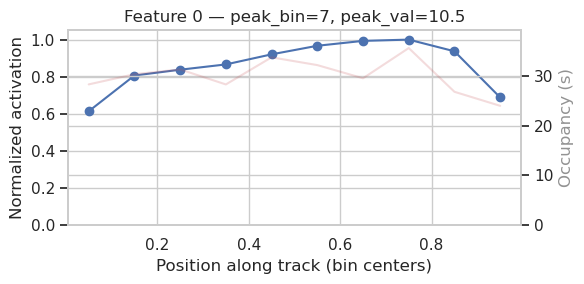

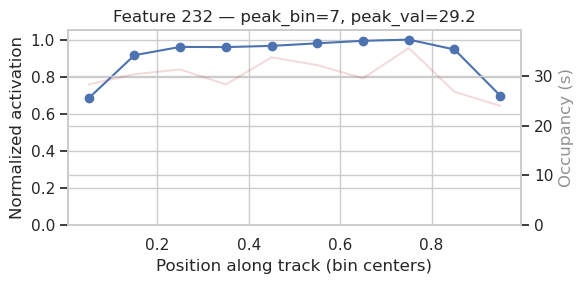

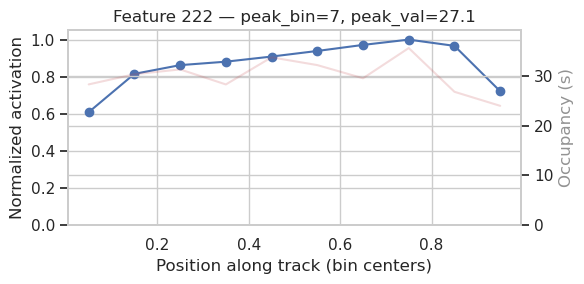

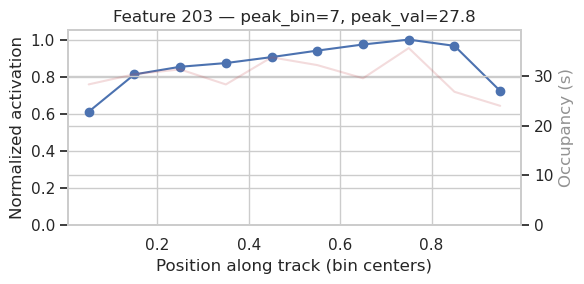

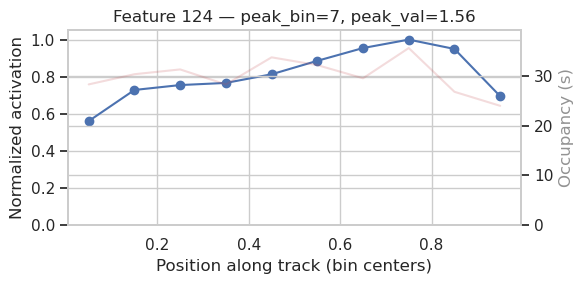

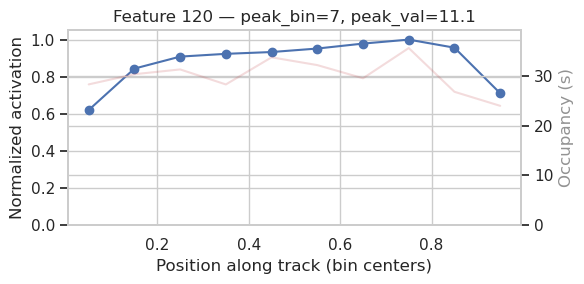

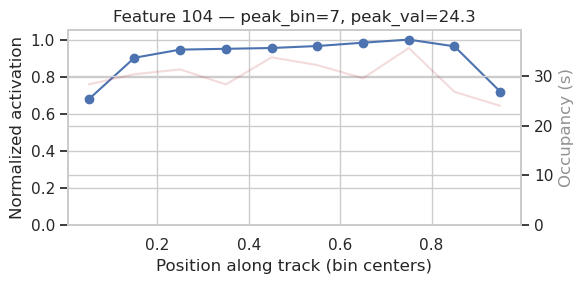

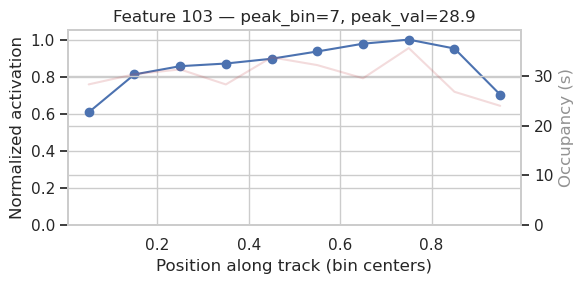

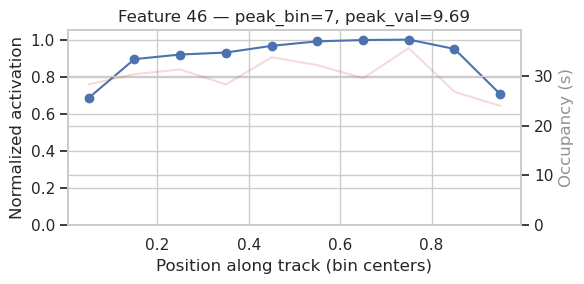

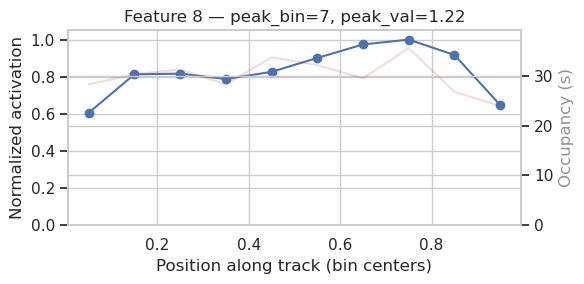

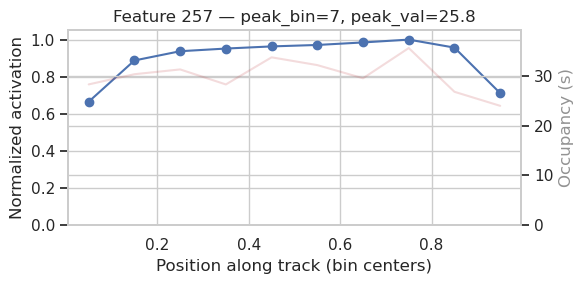

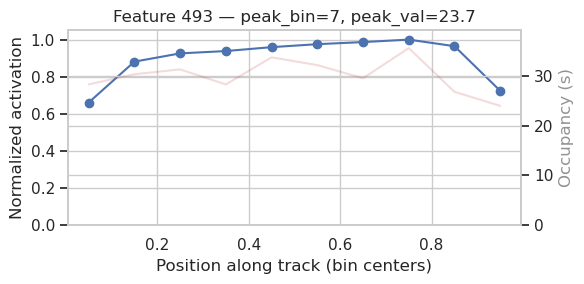

Done. Ratemaps saved to: feature_ratemaps


In [94]:
"""For a particular feature, get times it fired + stim deta at these times."""

# Inputs you already have:
# pos: shape (T,) continuous linear position
# features_df["feature_idx"]:   shape (T, F) continuous activations (or binary 0/1)
# features_df["example_idx"]:   shape (T,) time vector (optional) or assume uniform sampling dt

from scipy.ndimage import gaussian_filter1d
import os

features_df = acts_df[acts_df["instance_idx"] == 1].reset_index(drop=True)  # choose instance

# Parameters (tune as needed)
n_bins = 10
sigma_bins = 1.0            # smoothing sigma in bin units. Set to 0 to skip smoothing.
min_occupancy_s = 0.2       # seconds minimum occupancy per bin; set 0 to ignore
save_dir = "feature_ratemaps"  # set None to show inline instead of saving
row_normalize = True        # if True, scale each feature's ratemap to [0,1] for visualization
plot_type = "line"          # "line" or "bar" (per feature)
figsize = (6,3)

# -----------------------------------------------------------------------

# Basic checks
assert 'feature_idx' in features_df.columns and 'example_idx' in features_df.columns, \
    "features_df must contain 'feature_idx' and 'example_idx' columns."

# If activation values exist, use them; else create implied activation_value = 1 per row (count)
if 'activation_value' in features_df.columns:
    features_df['activation_value'] = features_df['activation_value'].astype(float)
else:
    features_df['activation_value'] = 1.0

# Convert pos & t to numpy
pos = np.load("./positions.npy")
time = np.load("./timepoints.npy")
T = len(pos)
if 'time' in globals():
    t = np.asarray(time)
    # estimate dt as median diff; if irregular sampling you might compute occupancy per-sample differently
    dt = np.median(np.diff(t))
else:
    dt = 1.0   # assume uniform sampling; occupancy in "samples" units

# 1) define spatial bins and occupancy
edges = np.linspace(pos.min(), pos.max(), n_bins + 1)
bin_idx_all = np.digitize(pos, edges) - 1
bin_idx_all = np.clip(bin_idx_all, 0, n_bins-1)

# occupancy in seconds per bin
counts = np.bincount(bin_idx_all, minlength=n_bins)
T_bins = counts * dt
p_bins = T_bins / T_bins.sum()

# optionally mask low-occupancy bins
low_occ_mask = T_bins < min_occupancy_s

# 2) Map feature activations (rows) to bins using example_idx -> pos -> bin
# Make sure example_idx is integer and indices are within range
features_df = features_df.copy()
features_df['example_idx'] = features_df['example_idx'].astype(int)
features_df = features_df[(features_df['example_idx'] >= 0) & (features_df['example_idx'] < T)].reset_index(drop=True)
# Map example -> position bin
features_df['bin'] = bin_idx_all[features_df['example_idx'].values]

# 3) Aggregate activations per feature x bin
# We compute sum of activation_value per (feature, bin). For counts-based data this is just counts.
agg = features_df.groupby(['feature_idx', 'bin'])['activation_value'].sum().unstack(fill_value=0)  # shape: (n_features, n_bins)
# ensure all bins exist as columns
agg = agg.reindex(columns=np.arange(n_bins), fill_value=0)

# 4) Convert aggregated activations to occupancy-normalized ratemap
# rate = total_activation_in_bin / occupancy_seconds_in_bin
# If dt units are samples, this gives activations per second if activation_value counted spikes per sample
occ = T_bins.copy().astype(float)
occ[occ == 0] = np.nan  # avoid division by zero; we'll mask these later
ratemap = agg.values / occ[np.newaxis, :]   # shape (n_features, n_bins)

# 5) smoothing (optional)
if sigma_bins > 0:
    # for a linear track use mode='constant' to avoid wrap-around
    ratemap_sm = gaussian_filter1d(ratemap, sigma=sigma_bins, axis=1, mode='constant')
else:
    ratemap_sm = ratemap

# 6) prepare plotting folder
if save_dir is not None:
    os.makedirs(save_dir, exist_ok=True)

# Function to compute a simple selectivity metric (peak / mean) for ordering
peak_over_mean = (ratemap_sm.max(axis=1) + 1e-12) / (np.nanmean(ratemap_sm, axis=1) + 1e-12)
# order features by peak bin (so place-like fields line up) or by peak_over_mean
peak_bin = np.nanargmax(ratemap_sm, axis=1)
order = np.argsort(peak_bin)  # primary sort by peak location
# alternative: order = np.argsort(-peak_over_mean)  # by selectivity

# 7) iterate and plot each feature's ratemap
import math
from matplotlib import gridspec

feature_ids = agg.index.values
for i_feat in order:
    feat = feature_ids[i_feat]  # actual feature_idx label (could be non-contiguous)
    row = ratemap_sm[i_feat, :].copy()
    # mask low-occupancy bins for plotting clarity
    row_vis = row.copy()
    row_vis[low_occ_mask] = np.nan

    if row_normalize:
        mx = np.nanmax(row_vis)
        if np.isfinite(mx) and mx > 0:
            row_vis = row_vis / mx

    # build plot
    fig, ax = plt.subplots(figsize=figsize)
    bins_centers = (edges[:-1] + edges[1:]) / 2.0

    if plot_type == "line":
        ax.plot(bins_centers, row_vis, marker='o', linestyle='-')
        ax.set_ylim(0, 1.05 if row_normalize else None)
    else:  # bar
        ax.bar(bins_centers, row_vis, width=(edges[1]-edges[0])*0.9, align='center')
        if row_normalize:
            ax.set_ylim(0,1.05)

    ax.set_xlabel("Position along track (bin centers)")
    ax.set_ylabel("Normalized activation" if row_normalize else "Activation / sec")
    ax.set_title(f"Feature {feat} — peak_bin={peak_bin[i_feat]}, peak_val={ratemap_sm[i_feat].max():.3g}")
    # optionally annotate occupancy under plot
    ax2 = ax.twinx()
    ax2.plot(bins_centers, T_bins, color='r', alpha=0.2)
    ax2.set_ylabel("Occupancy (s)", alpha=0.5)
    ax2.set_ylim(0, max(T_bins)*1.1)

    plt.tight_layout()
    plt.show()

    if save_dir:
        fname = os.path.join(save_dir, f"ratemap_feature_{feat}.png")
        fig.savefig(fname, dpi=150)
        plt.close(fig)

# 8) Summary DF of metrics (optional)
metrics_df = pd.DataFrame({
    "feature_idx": feature_ids,
    "peak_bin": peak_bin,
    "peak_value": ratemap_sm.max(axis=1),
    "mean_value": np.nanmean(ratemap_sm, axis=1),
    "selectivity": peak_over_mean
})
metrics_df = metrics_df.sort_values(['peak_bin', 'selectivity'], ascending=[True, False]).reset_index(drop=True)
metrics_df.to_csv(os.path.join(save_dir, "feature_ratemap_metrics.csv"), index=False)
print("Done. Ratemaps saved to:", save_dir)



## Validate results with PCA

Explained variance ratio (PC1..): [0.0118 0.011  0.011  0.0109 0.0109 0.0108]


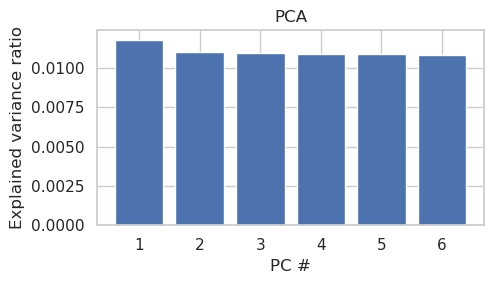

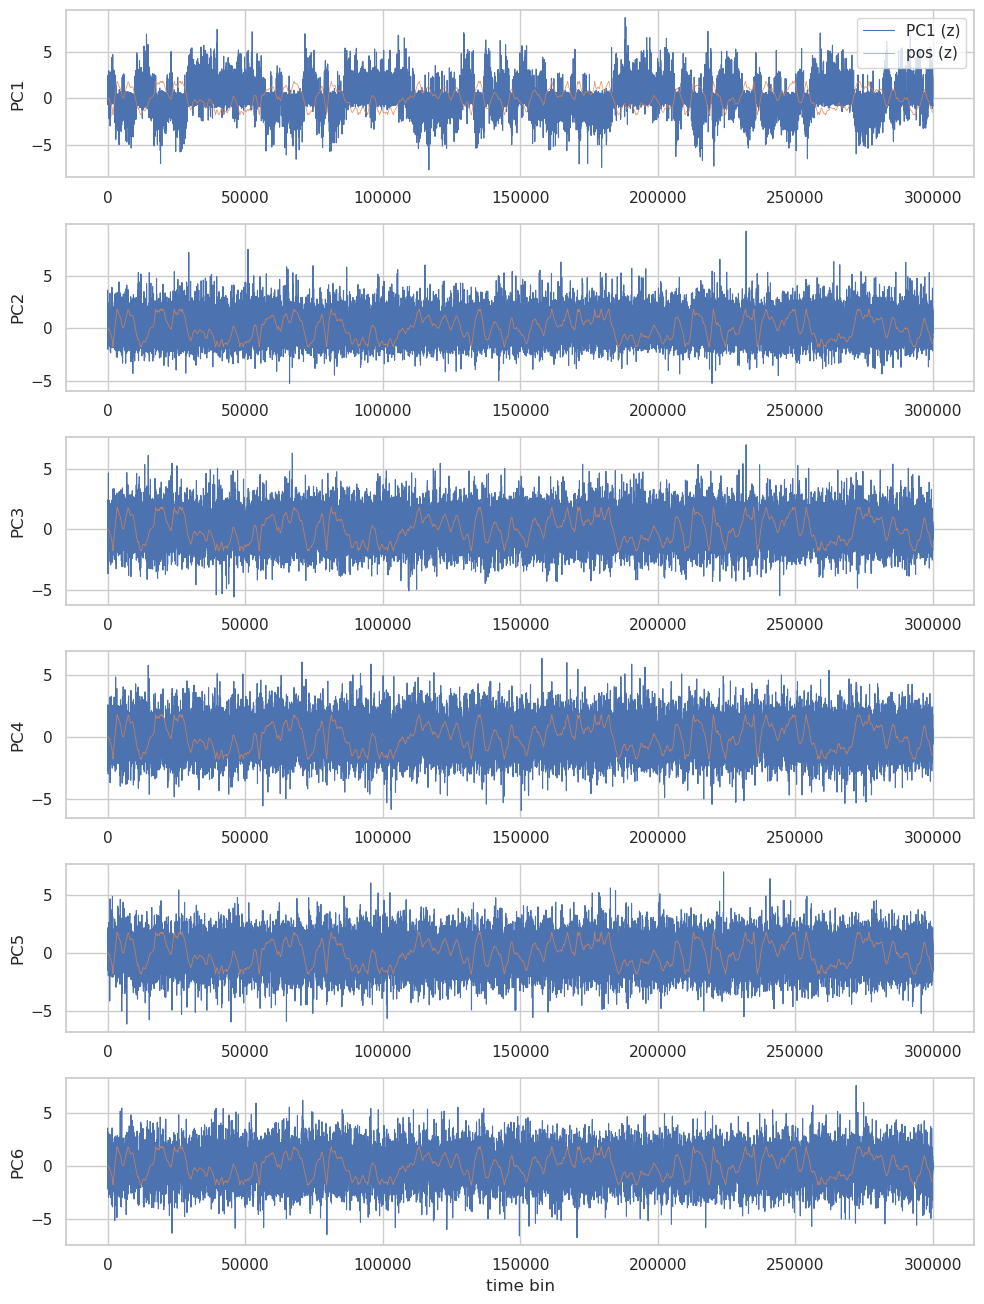

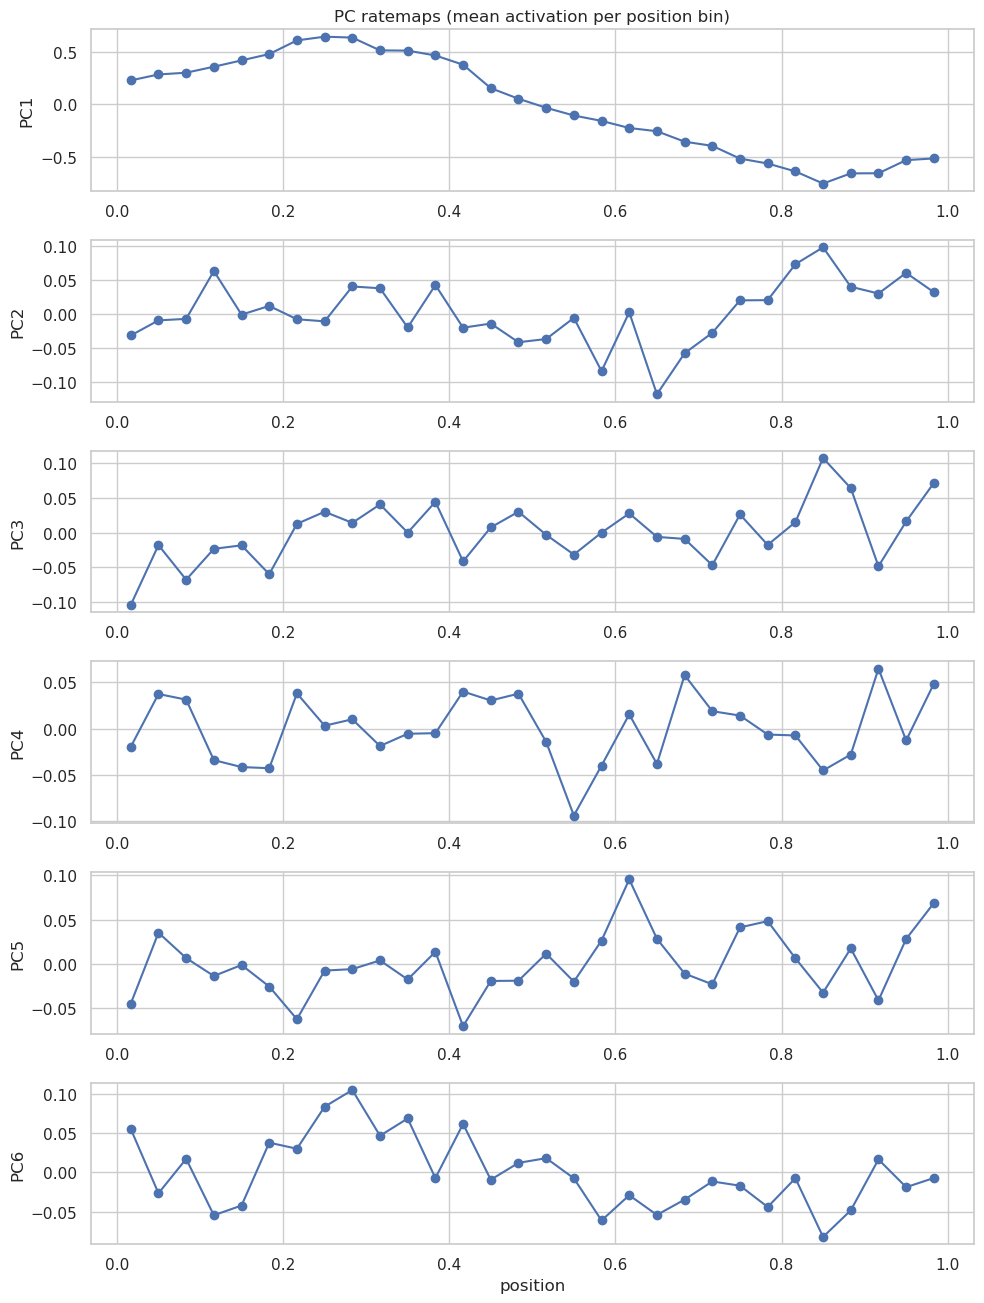

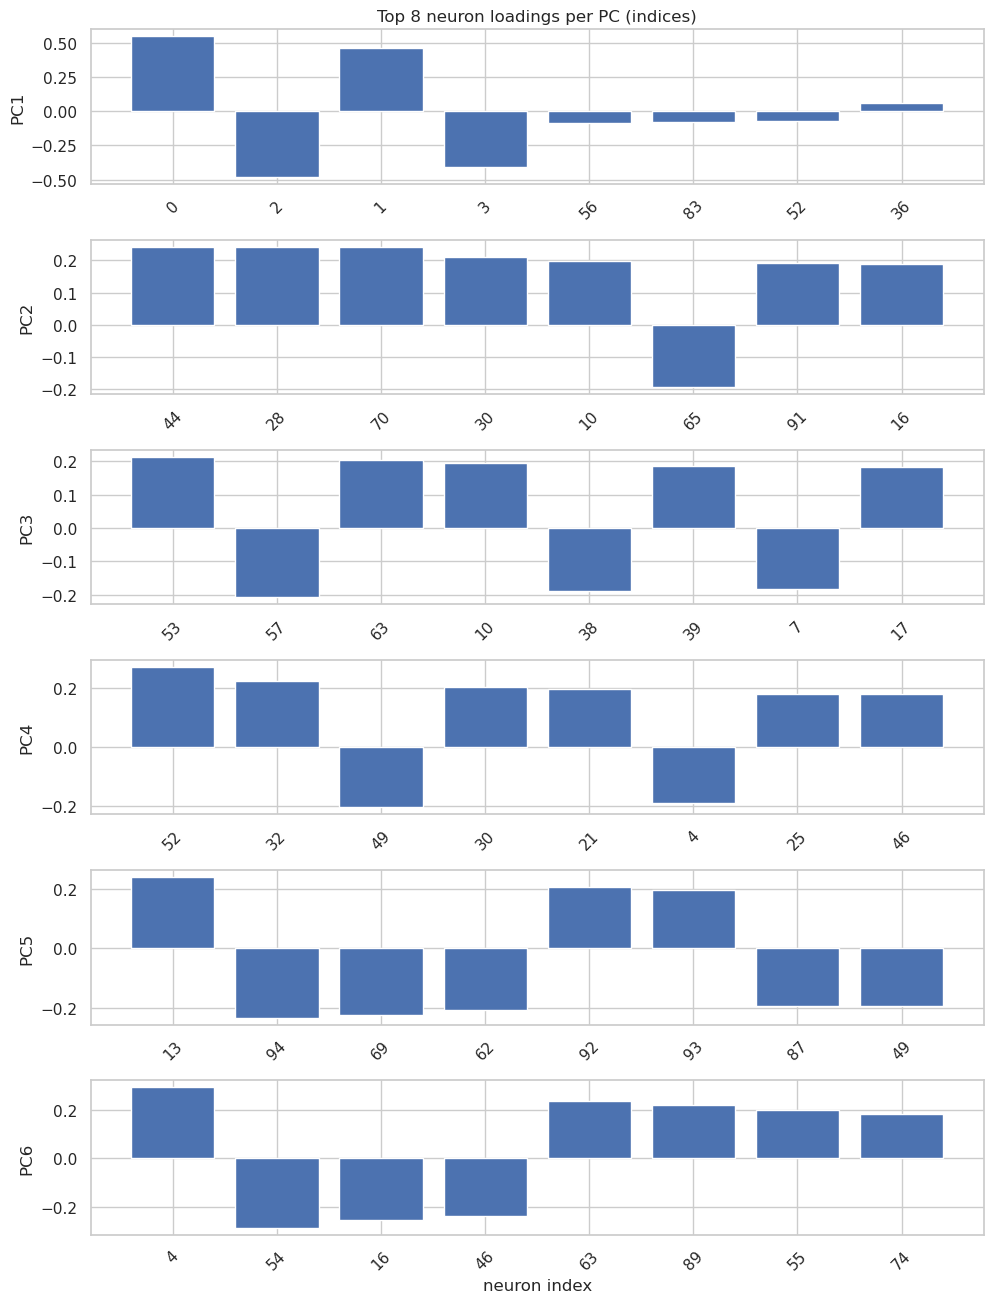

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------- USER: ensure spike_cts (T, N) and pos (T,) are in scope ----------
# Example:
# spike_cts = np.load("spike_cts.npy")   # shape (T, N)
# pos = np.load("pos.npy")               # shape (T,)
# ---------------------------------------------------------------------------

def simple_pca_inspect(spike_cts, pos, n_components=6, n_pos_bins=30, smoothing_sigma=None):
    """
    Minimal PCA + plots for interpretation.
    Inputs:
      - spike_cts: (T, N) array of spike counts/rates
      - pos: (T,) continuous position along track
      - n_components: number of PCs to compute and plot
      - n_pos_bins: bins for ratemap plots
      - smoothing_sigma: optional gaussian smoothing (float); None => no smoothing
    """
    # --- basic checks & preprocessing ---
    spike_cts = spike_cts.detach().cpu().to(t.float32).numpy()
    #pos = pos.detach().cpu().numpy()
    X = np.asarray(spike_cts).astype(float)
    pos = np.asarray(pos).ravel()
    if X.shape[0] != pos.shape[0]:
        raise ValueError("Time dimension mismatch: spike_cts.shape[0] != pos.shape[0]")
    # optional smoothing (along time axis)
    if smoothing_sigma is not None and smoothing_sigma > 0:
        from scipy.ndimage import gaussian_filter1d
        X = gaussian_filter1d(X, sigma=smoothing_sigma, axis=0, mode='reflect')
    # quick variance-stabilizing transform (optional but often useful)
    X = np.sqrt(X + 3./8.)
    # per-neuron z-score
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

    # --- PCA ---
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)          # (T, n_components)
    comps = pca.components_             # (n_components, N)
    explained = pca.explained_variance_ratio_

    print("Explained variance ratio (PC1..):", np.round(explained, 4))

    # --- plotting ---
    time = np.arange(X.shape[0])
    pos_z = (pos - pos.mean()) / (pos.std() + 1e-8)

    # 1) explained variance
    plt.figure(figsize=(5,3))
    plt.bar(np.arange(1, len(explained)+1), explained)
    plt.xlabel("PC #"); plt.ylabel("Explained variance ratio"); plt.title("PCA")
    plt.tight_layout(); plt.show()

    # 2) top K PC timecourses vs position (z-scored) for visual comparison
    K = min(n_components, pcs.shape[1])
    plt.figure(figsize=(10, 2.2 * K))
    for i in range(K):
        ax = plt.subplot(K, 1, i+1)
        pc_z = (pcs[:, i] - pcs[:, i].mean()) / (pcs[:, i].std() + 1e-8)
        ax.plot(time, pc_z, label=f"PC{i+1} (z)", linewidth=0.8)
        ax.plot(time, pos_z, label="pos (z)", linewidth=0.6, alpha=0.8)
        ax.set_ylabel(f"PC{i+1}")
        if i == 0:
            ax.legend(loc="upper right")
    plt.xlabel("time bin"); plt.tight_layout(); plt.show()

    # 3) ratemaps: mean PC activation per position bin
    bins = np.linspace(pos.min(), pos.max(), n_pos_bins+1)
    bin_idx = np.digitize(pos, bins) - 1
    bin_idx[bin_idx == n_pos_bins] = n_pos_bins - 1
    centers = 0.5 * (bins[:-1] + bins[1:])
    plt.figure(figsize=(10, 2.2 * K))
    for i in range(K):
        mean_by_bin = np.array([pcs[bin_idx == b, i].mean() if np.any(bin_idx==b) else np.nan
                                for b in range(n_pos_bins)])
        ax = plt.subplot(K, 1, i+1)
        ax.plot(centers, mean_by_bin, marker='o')
        ax.set_ylabel(f"PC{i+1}")
        if i == 0:
            ax.set_title("PC ratemaps (mean activation per position bin)")
    plt.xlabel("position"); plt.tight_layout(); plt.show()

    # 4) loadings: show top contributing neurons per PC
    #    we'll plot the absolute weights and list top-5 neuron indices per PC
    topk = 8
    plt.figure(figsize=(10, 2.2 * K))
    for i in range(K):
        w = comps[i]   # length N
        idx = np.argsort(np.abs(w))[::-1][:topk]
        ax = plt.subplot(K, 1, i+1)
        ax.bar(np.arange(topk), w[idx])
        ax.set_xticks(np.arange(topk))
        ax.set_xticklabels([str(j) for j in idx], rotation=45)
        ax.set_ylabel(f"PC{i+1}")
        if i == 0:
            ax.set_title(f"Top {topk} neuron loadings per PC (indices)")
    plt.xlabel("neuron index"); plt.tight_layout(); plt.show()

    # return objects for further inspection if needed
    return {"pca": pca, "pcs": pcs, "components": comps, "explained": explained, "pos_bins": centers}

# -------------------------
# Example usage 
# -------------------------

res = simple_pca_inspect(spike_cts, pos, n_components=6, n_pos_bins=30, smoothing_sigma=3)


Median SNR: 0.00010141888236164388 top neurons: [20 78 29  8 92 69  2  0  1  3]


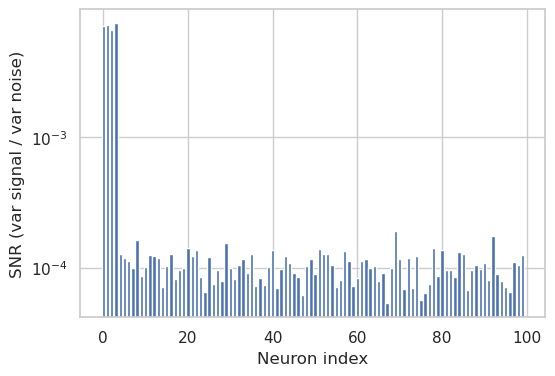

In [ ]:
# Check noise-to-signal ratio of spike data

# X: (T, N) spike counts, pos: (T,)
def per_neuron_snr(X, pos, n_pos_bins=30):
    # estimate signal as variance of neuron's mean firing across position bins
    bins = np.linspace(pos.min(), pos.max(), n_pos_bins+1)
    bin_idx = np.digitize(pos, bins) - 1
    bin_idx[bin_idx == n_pos_bins] = n_pos_bins-1
    N = X.shape[1]
    signal_var = np.zeros(N)
    noise_var  = np.zeros(N)
    for i in range(N):
        # mean rate per position bin
        means = [X[bin_idx==b, i].mean() if (bin_idx==b).any() else 0.0 for b in range(n_pos_bins)]
        signal_var[i] = np.var(means)
        # residual variance: average within-bin variance
        within = [X[bin_idx==b, i].var() if (bin_idx==b).any() else 0.0 for b in range(n_pos_bins)]
        noise_var[i] = np.mean(within)
    # SNR estimate = signal variance / noise variance (handle zero)
    snr = signal_var / (noise_var + 1e-8)
    return snr, signal_var, noise_var

spike_array = spike_cts.detach().cpu().to(t.float32).numpy()
snr, sig, nvar = per_neuron_snr(spike_array, pos)
print("Median SNR:", np.median(snr))

plt.figure(figsize=(6,4))
plt.bar(np.arange(len(snr)), snr)
plt.yscale('log')
plt.xlabel("Neuron index")
plt.ylabel("SNR (var signal / var noise)")
plt.show()


## Try other SAE training processing

(100, 300000)
(300000, 100)


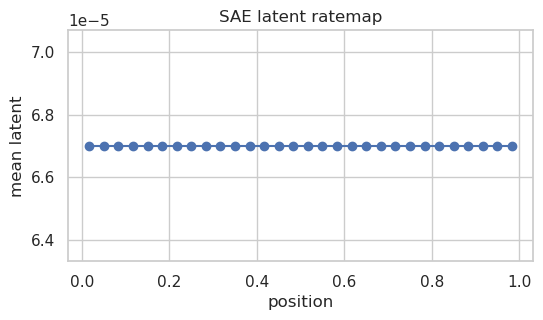

In [ ]:
# SAE_training_for_low_SNR.py
# Run in environment with: torch, sklearn, numpy, matplotlib, scipy

import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ------------------------
# Utilities
# ------------------------
def make_windows(X, k):
    # X: (T, N) -> returns windows (T, W, N) with reflect padding
    T, N = X.shape
    W = 2 * k + 1
    pad = np.pad(X, ((k, k), (0, 0)), mode='reflect')
    out = np.zeros((T, W, N), dtype=X.dtype)
    for t in range(T):
        out[t] = pad[t:t+W]
    return out

def per_neuron_weighting(X, eps=1e-8):
    # compute inverse-variance weights and normalize to mean 1
    v = X.var(axis=0)
    w = 1.0 / (v + eps)
    w = w / np.mean(w)
    return w.astype(np.float32)  # shape (N,)

def linear_cv_r2(z, pos, n_splits=5, alpha=1.0):
    # cross-validated ridge R^2 for z -> pos
    X = np.asarray(z)
    y = np.asarray(pos).ravel()
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = []
    for tr, te in cv.split(X):
        model = Ridge(alpha=alpha)
        model.fit(X[tr], y[tr])
        scores.append(model.score(X[te], y[te]))
    return np.mean(scores), np.std(scores)

# ------------------------
# Dataset
# ------------------------
class WindowDataset(Dataset):
    def __init__(self, X_windows, central_idx):
        # X_windows: (T, W, N), central_idx: int (index within window for target)
        self.Xw = X_windows.astype(np.float32)
        self.T, self.W, self.N = self.Xw.shape
        self.central_idx = central_idx

    def __len__(self):
        return self.T

    def __getitem__(self, i):
        inp = self.Xw[i].reshape(-1)          # flattened window
        target = self.Xw[i, self.central_idx] # central frame counts/rates (N,)
        return inp, target, i  # return i for ordering if needed

# ------------------------
# Model (small MLP encoder/decoder)
# ------------------------
class SmallAE(nn.Module):
    def __init__(self, input_dim, N_neurons, latent=1):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, N_neurons)
        )
    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out, z

# ------------------------
# Training function
# ------------------------
def train_sae(spike_cts, pos,
              k=5,                 # half-window -> window size = 2*k+1
              smoothing_sigma=None,# optional gaussian smoothing prior to windows
              latent_dim=1,
              batch_seq_len=256,   # use contiguous sequence batches of this length
              n_epochs=50,
              lr=1e-3,
              lambda_slow=1e-3,
              lambda_l1=1e-4,
              device='cpu'):
    # Preprocess: optional smoothing (helps SNR without PCA)
    if smoothing_sigma is not None and smoothing_sigma > 0:
        from scipy.ndimage import gaussian_filter1d
        X_smooth = gaussian_filter1d(spike_cts, sigma=smoothing_sigma, axis=0, mode='reflect')
    else:
        X_smooth = spike_cts.copy()

    # Build windows
    X_win = make_windows(X_smooth, k=k)   # (T, W, N)
    T, W, N = X_win.shape
    central = k

    # compute per-neuron weighting to equalize variance contributions
    neuron_weights = per_neuron_weighting(X_smooth)   # shape (N,)
    # convert to torch
    w_tensor = torch.from_numpy(neuron_weights).float().to(device)  # (N,)

    # make dataset and dataloader that yields contiguous blocks (no shuffle)
    ds = WindowDataset(X_win, central_idx=central)
    # We'll make batches that are contiguous sequences:
    def seq_loader(ds, batch_seq_len):
        T = len(ds)
        i = 0
        while i < T:
            j = min(i + batch_seq_len, T)
            batch = [ds[t] for t in range(i, j)]
            inp = np.stack([b[0] for b in batch], axis=0)
            tgt = np.stack([b[1] for b in batch], axis=0)
            idxs= np.array([b[2] for b in batch])
            yield torch.from_numpy(inp).float().to(device), torch.from_numpy(tgt).float().to(device), idxs
            i = j

    D = N * W
    model = SmallAE(input_dim=D, N_neurons=N, latent=latent_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    eps = 1e-8
    for epoch in range(1, n_epochs+1):
        model.train()
        epoch_loss = 0.0
        count = 0
        for xb, xtarget, idxs in seq_loader(ds, batch_seq_len):
            # xb: (B, D), xtarget: (B, N)
            xr, z = model(xb)   # xr: (B, N) raw outputs -> interpreted as log/linear rates
            # convert to positive rates
            rate = torch.nn.functional.softplus(xr) + 1e-8  # (B, N)
            # Poisson NLL per element: rate - x*log(rate)
            # apply per-neuron weighting w_tensor (shape (N,))
            recon_elem = (rate - xtarget * torch.log(rate + eps))  # (B, N)
            recon_weighted = recon_elem * w_tensor.unsqueeze(0)    # broadcast
            recon_loss = recon_weighted.sum(dim=1).mean()

            # slowness on latent z (z shape (B, latent_dim))
            if z.shape[0] > 1:
                slow_loss = ((z[1:] - z[:-1])**2).mean()
            else:
                slow_loss = torch.tensor(0.0, device=device)

            l1 = z.abs().mean()

            loss = recon_loss + lambda_slow * slow_loss + lambda_l1 * l1

            opt.zero_grad(); loss.backward(); opt.step()

            epoch_loss += float(loss.detach().cpu().item()) * xb.shape[0]
            count += xb.shape[0]

        avg_loss = epoch_loss / (count + 1e-12)

        # Evaluate latent -> pos decoding on full data (in eval mode)
        model.eval()
        with torch.no_grad():
            # get all z in sequence order
            all_z = []
            for xb_full, xt, idxs in seq_loader(ds, batch_seq_len):
                _, zbatch = model(xb_full)
                all_z.append(zbatch.detach().cpu().numpy())
            Z = np.vstack(all_z)    # (T, latent)
            cv_mean, cv_std = linear_cv_r2(Z, pos, n_splits=5, alpha=1.0)

        #print(f"Epoch {epoch:03d} | loss={avg_loss:.5f} | latent->pos CV R2 = {cv_mean:.4f} ± {cv_std:.4f}")

    # After training: return model and last latent/timecourse
    return model, Z, neuron_weights

# ------------------------
# Example run (user provides spike_cts, pos as numpy arrays)
# ------------------------
# Example parameters — tweak to your bin size / data
# spike_cts : (T,N) numpy counts
# pos       : (T,) continuous along track

# Uncomment and replace the following two lines with your data
spike_matrix = np.load("./spike_matrix.npy")
print(spike_matrix.shape)  # (N, T)
spike_cts = spike_matrix.T # shape (T, N)
print(spike_cts.shape)
pos = np.load("./positions.npy")

# Then run:
model, Z, neuron_weights = train_sae(spike_cts, pos,
                                     k=5,
                                      smoothing_sigma=2,
                                      latent_dim=4,
                                      batch_seq_len=512,
                                      n_epochs=100,
                                      lr=1e-3,
                                      lambda_slow=1e-3,
                                      lambda_l1=1e-4,
                                      device='cuda')  # or 'cpu'




Latent dim 0: mean=6.7e-05, std=0


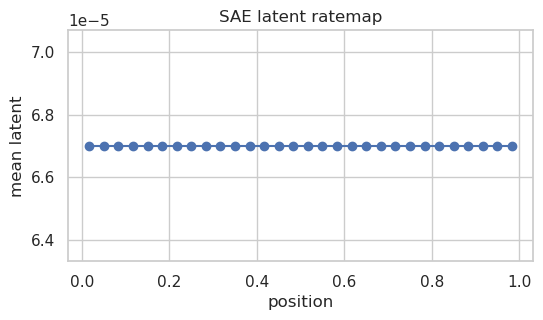

Latent dim 1: mean=0.000246, std=0


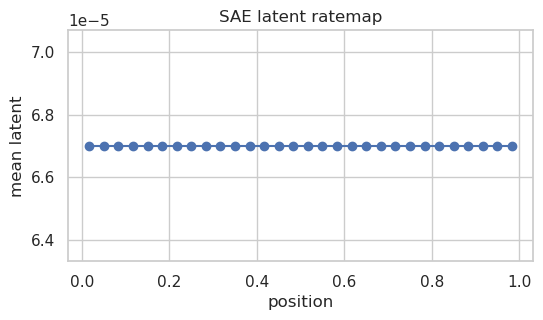

Latent dim 2: mean=-9e-05, std=0


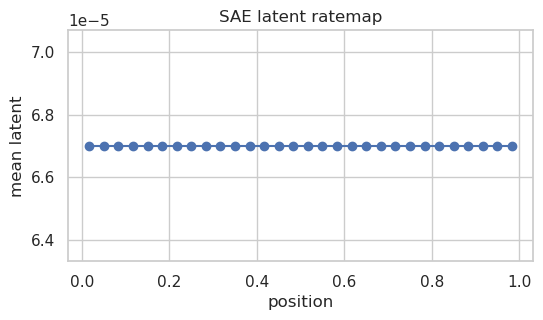

Latent dim 3: mean=0.000157, std=0


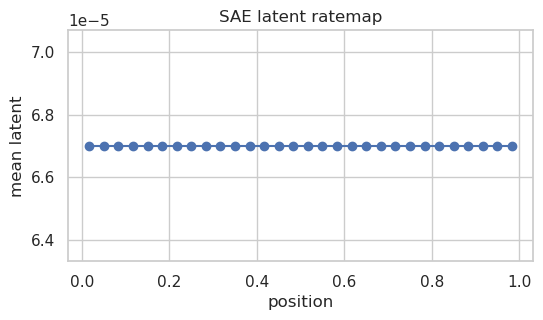

In [99]:
# ------------------------
# Quick plotting helper for the learned latent
# ------------------------
def plot_latent_ratemap(Z, pos, n_bins=30, title="latent ratemap"):
    # Z: (T, latent) choose first dim if multi
    for i in range(Z.shape[1]):
        print(f"Latent dim {i}: mean={Z[:,i].mean():.3g}, std={Z[:,i].std():.3g}")
        z = np.asarray(Z)[:, 0]
        bins = np.linspace(pos.min(), pos.max(), n_bins + 1)
        bin_idx = np.digitize(pos, bins) - 1
        centers = 0.5 * (bins[:-1] + bins[1:])
        mean_by_bin = np.array([z[bin_idx == b].mean() if np.any(bin_idx==b) else np.nan for b in range(n_bins)])
        plt.figure(figsize=(6,3))
        plt.plot(centers, mean_by_bin, marker='o')
        plt.xlabel("position"); plt.ylabel("mean latent"); plt.title(title)
        plt.show()

    
plot_latent_ratemap(Z, pos, n_bins=30, title="SAE latent ratemap")